In [4]:
import librosa
import numpy as np

import sklearn
import sklearn.cluster
import sklearn.pipeline

import matplotlib.pyplot as plt
import seaborn
seaborn.set(style='ticks')
%matplotlib inline

In [5]:
# We'll build the feature pipeline object here

# First stage is a mel-frequency specrogram of bounded range
MelSpec = librosa.util.FeatureExtractor(librosa.feature.melspectrogram, 
                                        n_fft=2048,
                                        n_mels=128,
                                        fmax=librosa.midi_to_hz(116), 
                                        fmin=librosa.midi_to_hz(24))

# Second stage is log-amplitude; power is relative to peak in the signal
LogAmp = librosa.util.FeatureExtractor(librosa.logamplitude, 
                                       ref_power=np.max)


# Third stage transposes the data so that frames become samples
Transpose = librosa.util.FeatureExtractor(np.transpose)

# Last stage stacks all samples together into one matrix for training
Stack = librosa.util.FeatureExtractor(np.vstack, iterate=False)

In [6]:
# Now, build a learning object.  We'll use mini-batch k-means with default parameters.
C = sklearn.cluster.MiniBatchKMeans()

In [7]:
# Now, chain them all together into a pipeline
ClusterPipe = sklearn.pipeline.Pipeline([('Mel spectrogram', MelSpec), 
                                         ('Log amplitude', LogAmp),
                                         ('Transpose', Transpose),
                                         ('Stack', Stack),
                                         ('Cluster', C)])

In [9]:
# Let's build a model using just the first 20 seconds of the example track

y_train, sr = librosa.load('./203726__genelythgow__4-bell-piano-hhits.wav', duration=4, offset=0.0)

In [10]:
# Fit the model.  
# [y_train] will be passed through the entire feature pipeline before k-means is trained
ClusterPipe.fit([y_train])

Pipeline(steps=[('Mel spectrogram', FeatureExtractor(fmax=array([ 6644.87516]), fmin=array([ 32.7032]),
         function=<function melspectrogram at 0x7f6a5e9420c8>, n_fft=2048,
         n_mels=128, target=None)), ('Log amplitude', FeatureExtractor(function=<function logamplitude at 0x7f6a5e9305f0>,
       ...sters=8,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0))])

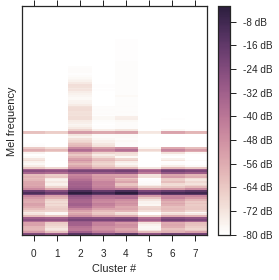

In [11]:
# We can plot the resulting centroids
plt.figure(figsize=(4, 4))

librosa.display.specshow(C.cluster_centers_.T)

plt.xticks(range(len(C.cluster_centers_)))
plt.xlabel('Cluster #')

plt.ylabel('Mel frequency')

plt.colorbar(format='%+02.0f dB')

plt.tight_layout()

In [12]:
# Now we can make predictions, in this case, frame-level cluster identifiers.
# Let's run it on the training data, just to be sure it worked.
ClusterPipe.predict([y_train])

array([2, 2, 2, 3, 4, 4, 4, 4, 4, 4, 3, 2, 2, 3, 4, 4, 4, 4, 4, 6, 6, 3, 2,
       2, 3, 4, 4, 4, 6, 6, 6, 6, 2, 2, 3, 3, 4, 6, 6, 6, 6, 6, 6, 3, 3, 3,
       6, 6, 6, 6, 7, 7, 7, 6, 3, 3, 3, 6, 6, 6, 7, 7, 7, 1, 3, 3, 3, 0, 6,
       6, 7, 7, 7, 7, 7, 0, 0, 0, 7, 7, 1, 1, 1, 1, 1, 7, 0, 0, 0, 0, 7, 7,
       7, 7, 7, 7, 7, 0, 0, 0, 7, 1, 1, 1, 1, 1, 1, 7, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 5, 5, 5, 0, 0, 1, 1, 1, 1, 5, 5, 5,
       5, 5, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5,
       5, 1, 1, 5, 5, 5, 5, 5, 5, 5, 0, 3], dtype=int32)

In [14]:
# Now we can test it on a different portion of the track: [20s, 25s]

y_test, sr = librosa.load('./203726__genelythgow__4-bell-piano-hhits.wav', duration=5, offset=4.0)

In [15]:
ClusterPipe.predict([y_test])

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 2, 2, 2, 2, 3,
       3, 3, 3, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0,
       0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5,
       0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2,
       2, 3, 3, 3, 3, 3, 3, 0, 0, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 2, 2, 2,
       3, 3, 3, 3, 3, 0, 0, 3, 2], dtype=int32)